In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder

tqdm.pandas()

In [3]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = True
edges_hex = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
edges_shp = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, "shp_drive", f"edges_hex_{get_resolution_buffered_suffix(resolution, buffered)}.shp")).set_index("h3_id")
hex_agg = aggregate_hex(edges_hex)
hex_agg_tfidf = tfidf(hex_agg)

In [7]:
X = torch.Tensor(hex_agg.values)
X_tfidf = torch.Tensor(hex_agg_tfidf.values)

batch_size = 200
num_workers = 5

X_dl = DataLoader(X, batch_size=batch_size, num_workers=num_workers)
X_tfidf_dl = DataLoader(X_tfidf, batch_size=batch_size, num_workers=num_workers)

n = X.shape[1]

In [18]:
wandb_logger = WandbLogger()
run = wandb.init(project="osm-autoencoder", reinit=True)

model = LitAutoEncoder(in_dim=n, hidden_dim=64, code_dim=10)
trainer = pl.Trainer(gpus=1, max_epochs=40, logger=wandb_logger)
trainer.fit(model, X_tfidf_dl)

y = model(X)
y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
y_df.index = hex_agg.index

run.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 9.1 K 
1 | decoder | Sequential | 9.2 K 
---------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s, loss=0.000957, v_num=long]


train_loss_epoch,0.00096
epoch,39
trainer/global_step,399
_runtime,150
_timestamp,1620930783
_step,47
train_loss_step,0.00068


train_loss_epoch,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_step,█▆▄▃▂▁▁▁


In [19]:
from sklearn.preprocessing import normalize
y_df = pd.DataFrame(normalize(y_df, norm="l2"), columns=y_df.columns, index=y_df.index)  # cosine metric
y_df["cluster"] = cluster_hdbscan(y_df, min_cluster_size=13, metric="euclidean")[0]
hexagons_clustered = hexagons.join(y_df).dropna()

In [26]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
y_df["cluster"] = pd.Series(agglomerative_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

In [30]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=15)
y_df["cluster"] = pd.Series(spectral_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

<AxesSubplot:>

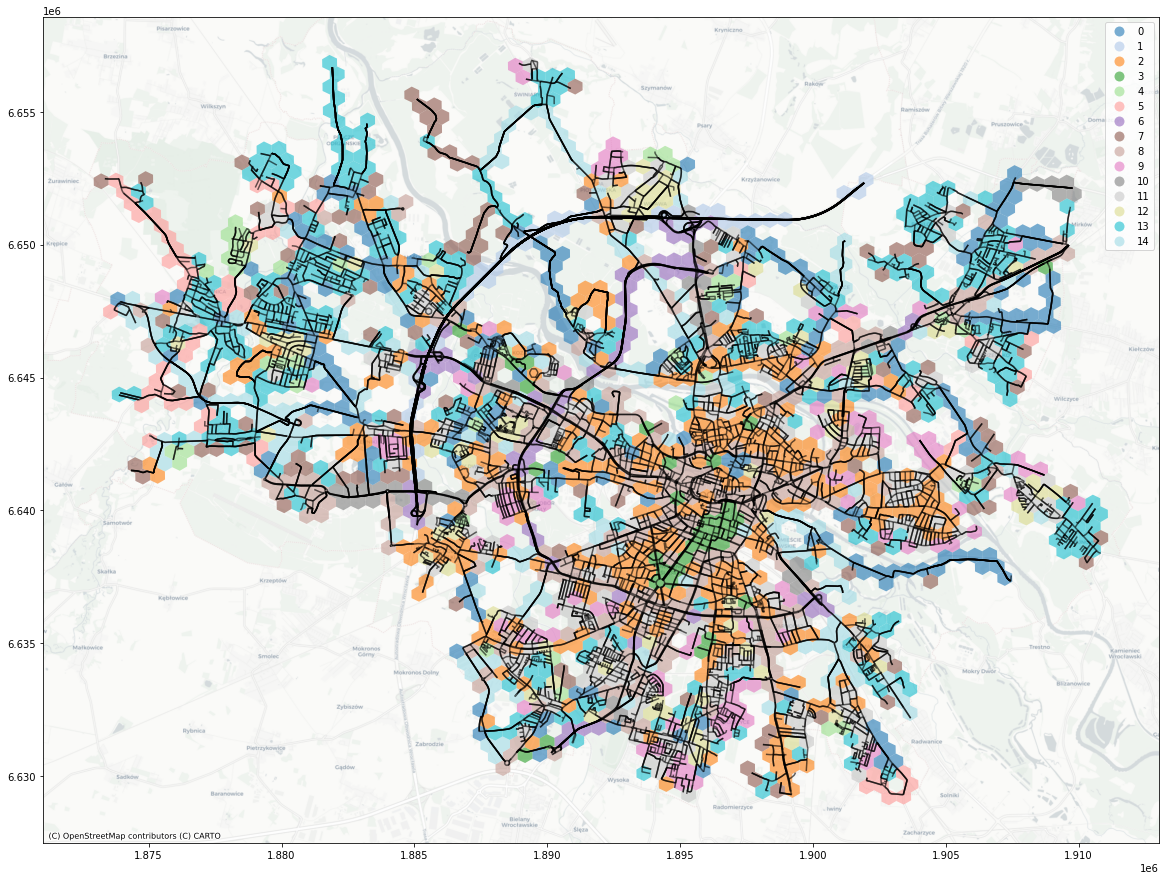

In [31]:
from src.tools.vis_utils import plot_hexagons_map

plot_hexagons_map(hexagons_clustered, edges_hex, "cluster")

In [37]:
from src.tools.vis_utils import plot_clusters
embedding = reduce_umap(y_df.drop(columns="cluster"), n_components=2, n_neighbors=15, metric="euclidean")[0]
embedding["cluster"] = y_df["cluster"]
plot_clusters(embedding)